# Raise error when loading VCF file by Pysam

We load the VCF by Pysam module and encounter a fatal error.

In [1]:
import pysam

last = None
vcf = "data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz"
with pysam.VariantFile(vcf) as f:
    for s in f:
        last = s

OSError: unable to parse next record

In [2]:
print(last)

chr6	28509805	.	G	A	50	PASS	platforms=5;platformnames=Illumina,PacBio,CG,10X,Solid;datasets=5;datasetnames=HiSeqPE300x,CCS15kb_20kb,CGnormal,10XChromiumLR,SolidSE75bp;callsets=7;callsetnames=HiSeqPE300xGATK,CCS15kb_20kbDV,CCS15kb_20kbGATK4,CGnormal,HiSeqPE300xfreebayes,10XLRGATK,SolidSE75GATKHC;datasetsmissingcall=IonExome;callable=CS_HiSeqPE300xGATK_callable,CS_CCS15kb_20kbDV_callable,CS_10XLRGATK_callable,CS_CCS15kb_20kbGATK4_callable,CS_CGnormal_callable,CS_HiSeqPE300xfreebayes_callable	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	0|1:822:166,134:218,192:630:0/1:.:PATMAT



The above result indicates that the improper record is behind chr6:28509805. The behind region is the MHC region.

# Inspect error records

Next, we inspected the improper records and found that the item count (5) of the FORMAT column is unequal to the item count (7) of the SAMPLE/INTEGRATION column.

Remove the redundant items from SAMPLE will solve the problem.

We provided a python script (`revise_vcf.py`) to revise the VCF file.

In [3]:
import gzip

vcf = "data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz"

n = 0
with gzip.open(vcf, "rt") as f:
    for line in f:
        if not line.startswith("#"):
            row = line.strip("\n").split("\t")
            if row[0] == "chr6" and int(row[1]) >= 28509805:
                print(line.strip("\n"))
                n += 1
                if n >= 10:
                    break

chr6	28509805	.	G	A	50	PASS	platforms=5;platformnames=Illumina,PacBio,CG,10X,Solid;datasets=5;datasetnames=HiSeqPE300x,CCS15kb_20kb,CGnormal,10XChromiumLR,SolidSE75bp;callsets=7;callsetnames=HiSeqPE300xGATK,CCS15kb_20kbDV,CCS15kb_20kbGATK4,CGnormal,HiSeqPE300xfreebayes,10XLRGATK,SolidSE75GATKHC;datasetsmissingcall=IonExome;callable=CS_HiSeqPE300xGATK_callable,CS_CCS15kb_20kbDV_callable,CS_10XLRGATK_callable,CS_CCS15kb_20kbGATK4_callable,CS_CGnormal_callable,CS_HiSeqPE300xfreebayes_callable	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	0|1:822:166,134:218,192:630:0/1:.:PATMAT
chr6	28510118	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28511949	.	C	CG	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28511953	.	C	A	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28512023	.	C	T	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28512858	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28513056	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28513257	.	ATAA

# SNPs overlap between v4.2.1 and v3.3.2

v4.2.1 provides more variant calls at autosomal chromosomes.

In [4]:
import re
import gzip
import matplotlib.pyplot as plt
from matplotlib_venn import *

def load_snps(path):
    snps = list()
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            row = line.strip("\n").split("\t")
            chrom, position, ref, alt = row[0], row[1], row[3], row[4]
            if re.match("^chr[0-9]+$", chrom) is None:
                continue
            if len(ref) > 1:
                continue
            if len(alt) > 1:
                continue
            snps.append((chrom, position))
    return set(snps)

snps1 = load_snps("data/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer.vcf.gz")
snps2 = load_snps("data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz")

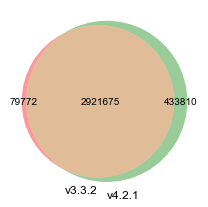

In [9]:
plt.figure(figsize=(4, 3))
venn2([snps1, snps2], set_labels=["v3.3.2", "v4.2.1"])
plt.tight_layout()
plt.show()